## This script contains code to plot the figures shown in the paper "Rules for body fat interventions based on an operating-point mechanism"
## Also contains part to replicate the mathematics shown in the paper and SI
##### Created by Alon Bar at Uri Alon's Lab for system biology, Weizmann institute

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
import matplotlib.cbook
import matplotlib as mpl
import matplotlib.image as mpimg
import time
import itertools
import seaborn as sns
import os
from sympy import *
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.fftpack import fft,fftfreq
from scipy.signal import medfilt, find_peaks
from scipy.io import loadmat
from scipy import stats
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from string import ascii_uppercase as abc; abc = abc
import statsmodels.api as sm

try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
    
def_color = [x['color'] for x in plt.cycler("color", plt.cm.Dark2.colors)]
def_color = [def_color[i] for i in [0,1,5,2,3]]
init_printing()

# Model's equations

In [2]:
L,F,al,bl,af,bf,R,ks,kl,u,be,n=symbols('L,F,a_L,\gamma_L,a_F,\gamma_F,R,u_{max},K_L,u,\gamma_\E,n',positive=True)
dF     = af*u   - bf*F - be
dL     = al*F*u - bl*L
K_L    = ks/(1+(L/kl)**n)
inv_Ku = solve(K_L - u,L)[0]
Lqst   = solve(dL,L)[0]
Lst    = Lqst.subs(u,solve(dF,u)[0])

# Figures properties

In [3]:
matplotlib.rcParams.update({'font.size': 15})
aps_diet  = dict(arrowstyle="<-",color=def_color[0],shrinkA=5,shrinkB=10,connectionstyle='arc3,rad=0.'  ,lw=3)
aps_appe  = dict(arrowstyle="<-",color=def_color[1],shrinkA=5,shrinkB=10,connectionstyle='arc3,rad=0.'  ,lw=3)
aps_fat   = dict(arrowstyle="<-",color=def_color[2],shrinkA=5,shrinkB=10,connectionstyle='arc3,rad=0.'  ,lw=2)
aps_lep   = dict(arrowstyle="<-",color=def_color[4],shrinkA=5,shrinkB=10,connectionstyle='arc3,rad=0.'  ,lw=2)
aps_k     = dict(arrowstyle="<-",color='k'         ,shrinkA=5,shrinkB=10,connectionstyle="arc3,rad=0."  ,lw=3)
aps_thina = dict(arrowstyle="<-",color='k'         ,shrinkA=5,shrinkB=10,connectionstyle="arc3,rad=-0.5",lw=1)
aps_thinb = dict(arrowstyle="<-",color='k'         ,shrinkA=5,shrinkB=10,connectionstyle="arc3,rad= 0.5",lw=1)
aps_flow  = dict(arrowstyle="<-",color='k'         ,shrinkA=5,shrinkB=10,connectionstyle="arc3,rad= 0",lw=1)
aps_flowb = dict(arrowstyle="<-",color='gray'      ,shrinkA=5,shrinkB=10,connectionstyle="arc3,rad= 0",lw=1)
aps_flowd = dict(arrowstyle="<->",color='k'         ,shrinkA=5,shrinkB=10,connectionstyle="arc3,rad= 0",lw=1)
bps       = dict(boxstyle="round", fc="w",alpha=0.75,lw=1)

def remove_top_right_frame(axes):
    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

def fmt_ax(ax,subs):
    ax.set_ylim([0,float(solve(dF,F)[0].subs(subs).subs(u,subs[ks]))]); 
    ax.set_xlim([0,subs[ks]*1.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('Fat, $F$')
    ax.set_xlabel('Food intake, ${u}$') 

## Fig 1 - The fat operating point lies at the intersection of the diet and appetite lines

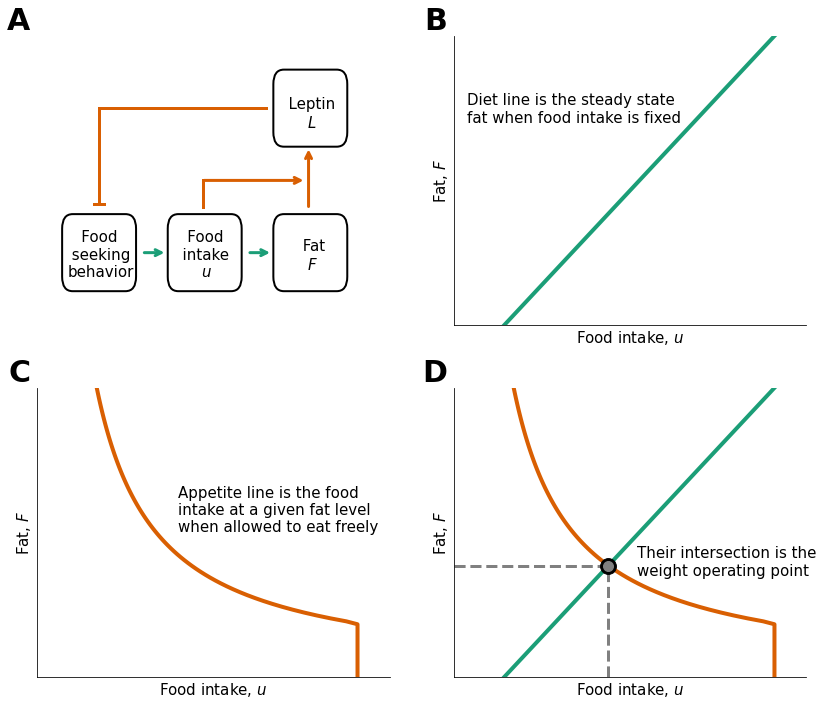

In [4]:
def get_numeric_nullclines_func(subs):
    app_ninf          = (bl*kl/(al*u))
    Fc                = float(app_ninf.subs(u,ks).subs(subs))
    diet_line_exp     = solve(dF,u)[0]
    appetite_line_exp = solve(app_ninf - F,u)[0]
    fstst_exp         = solve(Eq(diet_line_exp,appetite_line_exp),F)[0]
    ustst_exp         = diet_line_exp.subs(F,fstst_exp).simplify()

    stst              = [ustst_exp.subs(subs),fstst_exp.subs(subs)]
    null1             = lambdify(F,solve(dF,u)[0].subs(subs))
    null2_semi        = lambdify(F,solve(app_ninf - F,u)[0].subs(subs))

    def null2(F): 
        res = []
        for f in F:
            if f>Fc:
                res.append(null2_semi(f))
            else:
                 res.append(float(subs[ks]))
        return np.array(res)
    return null1,null2,stst

def plot_schem_on_ax(ax):
    ax.set_xlim([0,10]); ax.set_ylim([0,6]); ax.set_xticks([]); ax.set_yticks([]); ax.axis('off')
    bxloc = [1,4,7,7]  ; byloc = [1,1,1,4]

    ax.annotate(xy = [bxloc[0]-0.15,byloc[0]]       ,text='   Food \n seeking\nbehavior')
    ax.annotate(xy = [bxloc[1]-0.15,byloc[1]]       ,text='   Food \n  intake\n      $u$')
    ax.annotate(xy = [bxloc[2]-0.15,byloc[2] + .15] ,text='     Fat\n      $F$')
    ax.annotate(xy = [bxloc[3]-0.15,byloc[3] + .1]  ,text='  Leptin\n      $L$')
    rect1 = mpatches.FancyBboxPatch((bxloc[0], byloc[0]), 1.5, 1, linewidth=2, edgecolor='k', facecolor='none'); ax.add_patch(rect1)
    rect2 = mpatches.FancyBboxPatch((bxloc[1], byloc[1]), 1.5, 1, linewidth=2, edgecolor='k', facecolor='none'); ax.add_patch(rect2)
    rect3 = mpatches.FancyBboxPatch((bxloc[2], byloc[2]), 1.5, 1, linewidth=2, edgecolor='k', facecolor='none'); ax.add_patch(rect3)
    rect4 = mpatches.FancyBboxPatch((bxloc[3], byloc[3]), 1.5, 1, linewidth=2, edgecolor='k', facecolor='none'); ax.add_patch(rect4)

    ax.annotate(xy = [5.75,1.5],xytext=[6.75,1.5],text='',arrowprops=aps_diet)                                            
    ax.annotate(xy = [2.75,1.5],xytext=[3.75,1.5],text='',arrowprops=aps_diet)
    ax.annotate(xy = [7.7,2.25],xytext=[7.7,3.75],text='',arrowprops=aps_appe)
    ax.plot([6.5,1.75],[4.5,4.5],lw=3,c=def_color[1])
    ax.plot([1.75,1.75],[4.5,2.5],lw=3,c=def_color[1])
    ax.plot([1.6,1.9],[2.5,2.5],lw=3,c=def_color[1])
    
    
'''
Fig 1 -  theoretical lines and scheme
'''
dF               = af*u   - bf*F - be
subs             = {af:0.02,bf:0.025,al:1,bl:1,be:0.00625,kl:0.5,ks:2,n:16}
null1,null2,stst = get_numeric_nullclines_func(subs)
f_range          = np.linspace(0,float(solve(dF,F)[0].subs(subs).subs(u,subs[ks])),num=100)

plt.figure(figsize=(12,10)) ; ax1,ax2,ax3,ax4 = plt.subplot(221), plt.subplot(222), plt.subplot(223), plt.subplot(224)
plot_schem_on_ax(ax1)
ax2.plot(null1(f_range),f_range,c=def_color[0],lw=4) 
ax3.plot(null2(f_range),f_range,c=def_color[1],lw=4)
ax4.plot(null1(f_range),f_range,c=def_color[0],lw=4)
ax4.plot(null2(f_range),f_range,c=def_color[1],lw=4)
ax4.scatter(stst[0],stst[1],c='gray',s=100,zorder=4)
ax4.scatter(stst[0],stst[1],c='k',s=250,zorder=3)

ax4.plot([0,stst[0]],[stst[1],stst[1]],c='gray',ls='--',lw=3,zorder=-4)
ax4.plot([stst[0],stst[0]],[0,stst[1]],c='gray',ls='--',lw=3,zorder=-4)

ax1.annotate(xy = [4.45,3],xytext=[7.7,3],text='',arrowprops=aps_appe); ax1.plot([4.7,4.7],[2.45,3],c=def_color[1],lw=3)   
ax2.annotate(xy = [0.035,0.7],xycoords = 'axes fraction',text='Diet line is the steady state\nfat when food intake is fixed')
ax3.annotate(xy = [0.4,0.5],xycoords = 'axes fraction',text='Appetite line is the food\nintake at a given fat level\nwhen allowed to eat freely')
ax4.annotate(xy = [0.52,0.35],xycoords = 'axes fraction',text='Their intersection is the\nweight operating point')

[fmt_ax(ax,subs) for ax in [ax2,ax3,ax4]]
[ax.text(-0.02,1.1,abc[i],transform=ax.transAxes,fontsize = 30,fontweight='bold',va='top',ha='right') for i,ax in enumerate([ax1,ax2,ax3,ax4])]
remove_top_right_frame([ax2,ax3,ax4])

plt.tight_layout(); plt.show()

## Fig 2  - Experimental nullclines based on Harris et al

C:\Users\alonba\anaconda3\envs\biodata\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\alonba\anaconda3\envs\biodata\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in power
C:\Users\alonba\anaconda3\envs\biodata\lib\site-packages\ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in double_scalars


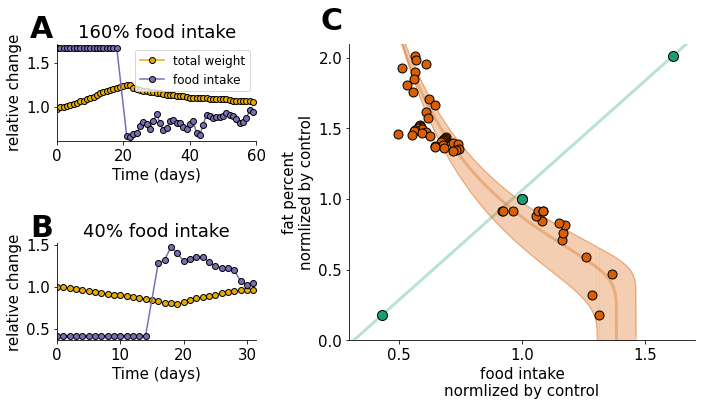

In [5]:
'''
Experiment data of controlled feeding
'''

bw160    = loadmat('./graphs from papers/exp_feeding_harris/exp_160/bw160.mat')['Body_weight_160']
bw100    = loadmat('./graphs from papers/exp_feeding_harris/exp_160/bw100.mat')['Body_weight_100']
fi160    = loadmat('./graphs from papers/exp_feeding_harris/exp_160/fi160.mat')['Food_intake_160']
fi100    = loadmat('./graphs from papers/exp_feeding_harris/exp_160/fi100.mat')['Food_intake_100'];fi100[6,1] = fi100[5,1]
bw160_ts            = interp1d(bw160[:,0] - bw160[0,0],bw160[:,1])
bw100_ts            = interp1d(bw100[:,0] - bw100[0,0],bw100[:,1])
fi160_ts            = interp1d(fi160[:,0] - fi160[0,0],fi160[:,1])
fi100_ts            = interp1d(fi100[:,0] - fi100[0,0],fi100[:,1])
ts160               = np.arange(0,68)
df160               = pd.DataFrame(index = ts160)
df160['intake_160'] = fi160_ts(ts160); df160['intake_100'] = fi100_ts(ts160)
df160['weight_160'] = bw160_ts(ts160); df160['weight_100'] = bw100_ts(ts160)
ndf160              = pd.DataFrame(index = ts160)
ndf160['weight']    = df160.weight_160/df160.weight_100
ndf160['intake']    = df160.intake_160/df160.intake_100
ndf160.index        = ndf160.index - ndf160.index[0]
ndf160_             = ndf160.copy().iloc[8:].reset_index()
df_weights_160                = pd.DataFrame(index = [0,4,12,39,'control'])
df_weights_160['total']       = [288,269,254,244,235]
df_weights_160['fat']         = [75,66,50,42,35]
df_weights_160['protein']     = [57,53,51,51,49]
df_weights_160['fat_percent'] = df_weights_160['fat']/df_weights_160['total']

bw40     = loadmat('./graphs from papers/exp_feeding_harris/exp_40/bw40.mat') ['Body_weight_40']
bw100    = loadmat('./graphs from papers/exp_feeding_harris/exp_40/bw100.mat')['Body_weight_100']
fi40     = loadmat('./graphs from papers/exp_feeding_harris/exp_40/fi40.mat') ['Food_intake_40']
fi100    = loadmat('./graphs from papers/exp_feeding_harris/exp_40/fi100.mat')['Food_intake_100']
bw40_ts             = interp1d(bw40 [:,0] - bw40 [0,0],bw40 [:,1])
bw100_ts            = interp1d(bw100[:,0] - bw100[0,0],bw100[:,1])
fi40_ts             = interp1d(fi40 [:,0] - fi40 [0,0],fi40 [:,1])
fi100_ts            = interp1d(fi100[:,0] - fi100[0,0],fi100[:,1])
ts40                = np.arange(0,44)
df40                = pd.DataFrame(index = ts40)
df40['intake_40']   = fi40_ts(ts40); df40['intake_100'] = fi100_ts(ts40)
df40['weight_40']   = bw40_ts(ts40); df40['weight_100'] = bw100_ts(ts40)
ndf40               = pd.DataFrame(index = ts40)
ndf40['weight']     = df40.weight_40/df40.weight_100
ndf40['intake']     = df40.intake_40/df40.intake_100
ndf40.index         = ndf40.index - ndf40.index[0]
ndf40_              = ndf40.copy().iloc[12:].reset_index().drop(columns=['index'])
df_weights_40                 = pd.DataFrame(index = [0,2,4,6,8,10,15,'control'])
df_weights_40['total']        = [154,174,180,199,201,211,224,235]
df_weights_40['fat']          = [3.6,10.5,16.5,21,22,25,26.5,35]
df_weights_40['protein']      = [37,39,40,43,44,45,48,49]
df_weights_40['fat_percent']  = df_weights_40['fat']/df_weights_40['total']

# plt.figure(figsize=(10,7))
# ax1,ax2,ax3,ax4 = plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)

# df160['intake_160'].plot(color=def_color[3],marker='o',markeredgecolor='k',ax=ax1)
# df160['intake_100'].plot(color=def_color[3],marker='o',markeredgecolor='gray',ax=ax1)
# ax1.legend(['160% intake','100% intake']); ax1.set_xlabel('time (dyas)'); ax1.set_ylabel('food intake (grams)')

# df160['weight_160'].plot(color=def_color[2],marker='o',markeredgecolor='k',ax=ax2)
# df160['weight_100'].plot(color=def_color[2],marker='o',markeredgecolor='gray',ax=ax2)
# ax2.legend(['160% intake','100% intake']); ax2.set_xlabel('time (dyas)'); ax2.set_ylabel('weight (grams)')

# df40['intake_40'].plot(color=def_color[3],marker='o',markeredgecolor='k',ax=ax3)
# df40['intake_100'].plot(color=def_color[3],marker='o',markeredgecolor='gray',ax=ax3)
# ax3.legend(['40% intake','100% intake']); ax3.set_xlabel('time (dyas)'); ax3.set_ylabel('food intake (grams)')

# df40['weight_40'].plot(color=def_color[2],marker='o',markeredgecolor='k',ax=ax4)
# df40['weight_100'].plot(color=def_color[2],marker='o',markeredgecolor='gray',ax=ax4)
# ax4.legend(['40% intake','100% intake']); ax4.set_xlabel('time (dyas)'); ax4.set_ylabel('weight (grams)')

# plt.tight_layout();plt.show()

def scatter_diet_line_by_norm(by='total',ax=[],return_data=False,c=[]):
    
    diet_intake_40  = [df40.iloc[12].intake_40,(df40.iloc[12].intake_100 + df160.iloc[12].intake_100)/2]
    diet_intake_160 = [df160.iloc[12].intake_160,(df40.iloc[12].intake_100 + df160.iloc[12].intake_100)/2]
    diet_weight_40  = [df_weights_40.iloc[0][by],(df_weights_40.iloc[4][by] + df_weights_160.iloc[4][by])/2]
    diet_weight_160 = [df_weights_160.iloc[0][by],(df_weights_40.iloc[4][by] + df_weights_160.iloc[4][by])/2]
    
    x_ = (df40.iloc[12].intake_100 + df160.iloc[12].intake_100)/2
    y_ = (df_weights_40.iloc[4][by] + df_weights_160.iloc[4][by])/2
    
    if not ax:
        ax= plt.subplot(111)
    if not c:
        ax.plot(diet_intake_40/x_,diet_weight_40/y_,'-o',lw=0,c=def_color[0],markeredgecolor='k',markersize=10)
        ax.plot(diet_intake_160/x_,diet_weight_160/y_,'-o',lw=0,c=def_color[1],markeredgecolor='k',markersize=10)
    else:
        ax.plot(diet_intake_40/x_,diet_weight_40/y_,'-o',lw=0,c=c,markeredgecolor='k',markersize=10)
        ax.plot(diet_intake_160/x_,diet_weight_160/y_,'-o',lw=0,c=c,markeredgecolor='k',markersize=10)
        
    if return_data:
        return diet_intake_40/x_,diet_weight_40/y_,diet_intake_160/x_,diet_weight_160/y_
    else:
        return x_,y_
 

'''
Fig 2 - Experimental dynamics and nullcines of the normlized phase portrait
'''

# normalizing data points to plot over the normlaized phase portriat
x_,y_         = scatter_diet_line_by_norm(by='fat_percent',ax=[],c=def_color[0])
app_dat       = np.zeros((11,2))
app_dat[:7,0] = fi40_ts(28+ df_weights_40.iloc[:-1].index.values.astype(int))/x_
app_dat[7:,0] = fi160_ts(29+ df_weights_160.iloc[:-1].index.values.astype(int))/x_
app_dat[:7,1] = df_weights_40.iloc[:-1].fat_percent/y_
app_dat[7:,1] = df_weights_160.iloc[:-1].fat_percent/y_
diet_dat      = scatter_diet_line_by_norm(by='fat_percent',ax=[],c=def_color[0],return_data=True)
diet_dat      = np.array([dat[0] for dat in diet_dat]).reshape((2,2)); plt.close()

# curve fitting the lines to the datapoints
def norm_diet(u,a,b):
    return a*u+b

def norm_appetite(u,A,ks,n):
    return A*(1/u) *(ks/u-1)**(1/n)

diet_pars    , cov = curve_fit(norm_diet, diet_dat[:,0], diet_dat[:,1]) # u0 in range 0-1
appetite_pars, cov = curve_fit(norm_appetite, app_dat[:,0], app_dat[:,1],bounds=(1,np.inf))# umax,n in bounds 1->inf
app_pars_sd        = np.sqrt(np.diag(cov))


fig  = plt.figure(figsize=(10,6))
gs   = gridspec.GridSpec(2, 5)
ax1  = plt.subplot(gs[0,0:2])
ax2  = plt.subplot(gs[1,0:2])
ax3  = plt.subplot(gs[0:2,2:5])

# panel A
ax1.plot(list(ndf160_.index),ndf160_.weight,color=def_color[2],marker='o',markeredgecolor='k')
ax1.plot(list(ndf160_.drop(index=[19,20]).index),ndf160_.drop(index=[19,20]).intake,color=def_color[3],marker='o',markeredgecolor='k')
ax1.set_title('160% food intake'); ax1.set_xlabel('Time (days)'); ax1.set_ylabel('relative change'); ax1.set_xlim([0,60])
ax1.legend(['total weight','food intake'],fontsize=12)

# panel B
ax2.plot(list(ndf40_.index),ndf40_.weight,color=def_color[2],marker='o',markeredgecolor='k')
ax2.plot(list(ndf40_.drop(index=15).index),ndf40_.drop(index=15).intake,color=def_color[3],marker='o',markeredgecolor='k')
ax2.set_title('40% food intake'); ax2.set_xlabel('Time (days)'); ax2.set_ylabel('relative change') ; ax2.set_xlim([0,31.5])

# panel C datapoints
x_,y_  = scatter_diet_line_by_norm(by='fat_percent',ax=ax3,c=def_color[0])
intfun = interp1d(df_weights_40.iloc[:-1].fat_percent.index,df_weights_40.iloc[:-1].fat_percent.values)
ax3.plot(fi40_ts(28+ np.array(range(16)))/x_,intfun(np.array(range(16))).astype(float)/y_,'o',c=def_color[1],lw=3,markeredgecolor='k',markersize=9)
intfun = interp1d(df_weights_160.iloc[:-1].fat_percent.index,df_weights_160.iloc[:-1].fat_percent.values)
ax3.plot(fi160_ts(29+ np.array(range(39)))/x_,intfun(np.array(range(39))).astype(float)/y_,'o',c=def_color[1],lw=3,markeredgecolor='k',markersize=9)

# panel C theoretical diet line
u_range = np.arange(0.2,2,0.1)
diet_   = [norm_diet(u_,diet_pars[0],diet_pars[1]) for u_ in u_range]
ax3.plot(u_range,diet_,c=def_color[0],zorder=-4,ls='-',lw=3,alpha=0.3)

# panel C theoretical appetite line
u_range  = np.array([appetite_pars[1] + i*app_pars_sd[1] for i in np.arange(-15,1+0.01,0.01)])
appe_    = [norm_appetite(u_,appetite_pars[0],appetite_pars[1],appetite_pars[2]) for u_ in u_range]
appe_p   = [norm_appetite(u_,appetite_pars[0]+app_pars_sd[0],appetite_pars[1]+app_pars_sd[1],appetite_pars[2]+app_pars_sd[2]) for u_ in u_range]
appe_n   = [norm_appetite(u_,appetite_pars[0]-app_pars_sd[0],appetite_pars[1]-app_pars_sd[1],appetite_pars[2]-app_pars_sd[2]) for u_ in u_range]

ax3.plot(u_range,appe_,c=def_color[1],zorder=-4,ls='-',lw=3,alpha=0.3)
ax3.plot(u_range,appe_p,c=def_color[1],zorder=-4,ls='-',lw=1,alpha=0.3)
ax3.plot(u_range,appe_n,c=def_color[1],zorder=-4,ls='-',lw=1,alpha=0.3)
ax3.fill_between(u_range,appe_n,appe_p,color=def_color[1],alpha=0.3)
midx = np.argmin(np.abs((u_range - (appetite_pars[1]-app_pars_sd[1])))) + 5
ax3.fill_between(u_range[midx:],appe_p[midx:],color=def_color[1],alpha=0.3)
ax3.set_xlabel('food intake\nnormlized by control'); ax3.set_ylabel('fat percent\nnormlized by control')
ax3.set_ylim([0,2.1]); ax3.set_xlim([0.3,1.7]); ax3.set_xticks([0.5,1,1.5]); ax3.set_yticks([0,0.5,1,1.5,2])

ax1.text(-0.02,1.3,'A',transform=ax1.transAxes,fontsize = 30,fontweight='bold',va='top',ha='right')
ax2.text(-0.02,1.3,'B',transform=ax2.transAxes,fontsize = 30,fontweight='bold',va='top',ha='right')
ax3.text(-0.02,1.124,'C',transform=ax3.transAxes,fontsize = 30,fontweight='bold',va='top',ha='right')
remove_top_right_frame([ax1,ax2,ax3])
plt.tight_layout(); plt.show()

# Fig 3 - shifting the lines

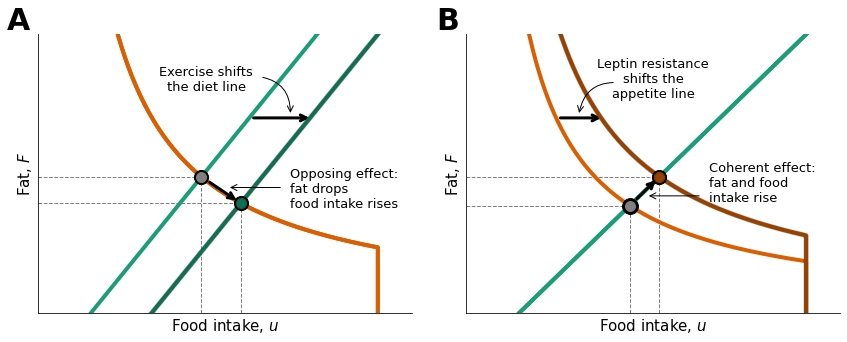

In [6]:
'''
Fig 3 - shifting the lines
'''

plt.figure(figsize=(12,5))
ax1,ax2 =  plt.subplot(121),plt.subplot(122)

## exercise ##
subs             = {af:0.02,bf:0.025,al:1,bl:1,be:0.00625,kl:0.5,ks:2}
null1,null2,stst = get_numeric_nullclines_func(subs); p1 = stst
f_range          = np.linspace(0,float(solve(dF,F)[0].subs(subs).subs(u,subs[ks])),num=1000)
ax1.plot(null1(f_range),f_range,c=def_color[0],lw=4)
ax1.plot(null2(f_range),f_range,c=def_color[1],lw=4)
ax1.scatter(stst[0],stst[1],c='gray',s=100,zorder=4)
ax1.scatter(stst[0],stst[1],c='k',s=200,zorder=3)

ax1.plot([0,stst[0]],[stst[1],stst[1]],c='gray',ls='--',lw=1,zorder=-4)
ax1.plot([stst[0],stst[0]],[0,stst[1]],c='gray',ls='--',lw=1,zorder=-4)

subs             = {af:0.02,bf:0.025,al:1,bl:1,be:0.0134,kl:0.5,ks:2,n:16}
null1,null2,stst = get_numeric_nullclines_func(subs); p2 = stst
ax1.plot(null1(f_range),f_range,c=def_color[0],lw=4)      ; ax1.plot(null1(f_range),f_range,c='k',lw=5,alpha=0.3)
ax1.plot(null2(f_range),f_range,c=def_color[1],lw=4)
ax1.scatter(stst[0],stst[1],c=def_color[0],s=100,zorder=4); ax1.scatter(stst[0],stst[1],c='k',s=100,zorder=4,alpha=0.3); ax1.scatter(stst[0],stst[1],c='k',s=200,zorder=3)

ax1.plot([0,stst[0]],[stst[1],stst[1]],c='gray',ls='--',lw=1,zorder=-4)
ax1.plot([stst[0],stst[0]],[0,stst[1]],c='gray',ls='--',lw=1,zorder=-4)

ax1.annotate(xy = [0.55,0.7],xytext=[0.74,0.7],xycoords='axes fraction',text='',arrowprops=aps_k,zorder=-4)
ax1.annotate(xy = [0.45,0.8],xycoords='axes fraction',text='Exercise shifts\nthe diet line',fontsize=13,ha='center')
ax1.annotate(xy = [0.575,0.85],xytext=[0.675,0.7],xycoords='axes fraction',text='',zorder=4,arrowprops=aps_thinb)
ax1.annotate(xy = p1,xytext=p2,xycoords='data',text='',arrowprops=aps_k,zorder=4)
ax1.annotate(xy = [0.675,0.38],xycoords='axes fraction',text='Opposing effect:\nfat drops\nfood intake rises',fontsize=13,ha='left')
ax1.annotate(xy = [0.675,0.45],xytext=[0.5,0.45],xycoords='axes fraction',text='',zorder=4,arrowprops=aps_flow)

fmt_ax(ax1,subs)

## leptin resistance ##
subs             = {af:0.02,bf:0.025,al:1,bl:1,be:0.00625,kl:0.5,ks:2,n:16}
null1,null2,stst = get_numeric_nullclines_func(subs); p3 = stst
f_range          = np.linspace(0,float(solve(dF,F)[0].subs(subs).subs(u,subs[ks])),num=1000)
ax2.plot(null1(f_range),f_range,c=def_color[0],lw=4)
ax2.plot(null2(f_range),f_range,c=def_color[1],lw=4)
ax2.scatter(stst[0],stst[1],c='gray',s=100,zorder=4)
ax2.scatter(stst[0],stst[1],c='k',s=250,zorder=3)
ax2.plot([0,stst[0]],[stst[1],stst[1]],c='gray',ls='--',lw=1,zorder=-4)
ax2.plot([stst[0],stst[0]],[0,stst[1]],c='gray',ls='--',lw=1,zorder=-4)

subs             = {af:0.02,bf:0.025,al:1,bl:1,be:0.00625,kl:0.75,ks:2,n:16}
null1,null2,stst = get_numeric_nullclines_func(subs); p4 = stst
f_range          = np.linspace(0,float(solve(dF,F)[0].subs(subs).subs(u,subs[ks])),num=1000)
ax2.plot(null1(f_range),f_range,c=def_color[0],lw=4)
ax2.plot(null2(f_range),f_range,c=def_color[1],lw=4)      ; ax2.plot(null2(f_range),f_range,c='k',lw=5,alpha=0.3)
ax2.scatter(stst[0],stst[1],c=def_color[1],s=100,zorder=4); ax2.scatter(stst[0],stst[1],c='k',s=100,zorder=4,alpha=0.3); ax2.scatter(stst[0],stst[1],c='k',s=200,zorder=3)

ax2.plot([0,stst[0]],[stst[1],stst[1]],c='gray',ls='--',lw=1,zorder=-4)
ax2.plot([stst[0],stst[0]],[0,stst[1]],c='gray',ls='--',lw=1,zorder=-4)

ax2.annotate(xy = [0.225,0.7],xytext=[0.375,0.7],xycoords='axes fraction',text='',arrowprops=aps_k,zorder=-4)
ax2.annotate(xy = [0.5,0.775],xycoords='axes fraction',text='Leptin resistance\nshifts the\nappetite line',fontsize=13,ha='center')
ax2.annotate(xy = [0.42,0.825],xytext=[0.3,0.7],xycoords='axes fraction',text='',zorder=4,arrowprops=aps_thina)
ax2.annotate(xy = p3,xytext=p4,xycoords='data',text='',arrowprops=aps_k,zorder=4)
ax2.annotate(xy = [0.65,0.4],xycoords='axes fraction',text='Coherent effect:\nfat and food\nintake rise',fontsize=13,ha='left')
ax2.annotate(xy = [0.65,0.42],xytext=[0.475,0.42],xycoords='axes fraction',text='',zorder=4,arrowprops=aps_flow)

fmt_ax(ax2,subs)

ax1.text(-0.02,1.1,'A',transform=ax1.transAxes,fontsize = 30,fontweight='bold',va='top',ha='right') 
ax2.text(-0.02,1.1,'B',transform=ax2.transAxes,fontsize = 30,fontweight='bold',va='top',ha='right') 
remove_top_right_frame([ax1,ax2])
plt.tight_layout(); plt.show()

# Fig 4 - pertubing the lines

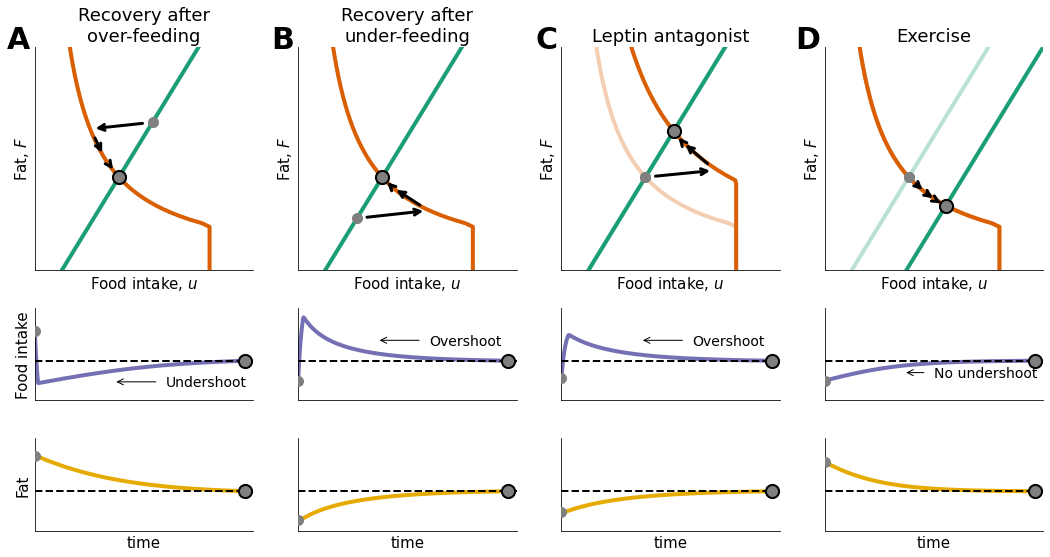

In [7]:
def plot_nullclines(subs,ax1,ls='-',sc='gray',alpha=1):
    null1,null2,stst = get_numeric_nullclines_func(subs)
    f_range          = np.linspace(0,4,num=200)#float(solve(dF,F)[0].subs(subs).subs(u,subs[ks])),num=100)
    ax1.plot(null1(f_range),f_range,color=def_color[0],lw=4,ls=ls,alpha=alpha)
    ax1.plot(null2(f_range),f_range,color=def_color[1],lw=4,ls=ls,alpha=alpha)
    if not sc:
        ax1.scatter(stst[0],stst[1],c='gray',s=100,zorder=4)
    else:
        ax1.scatter(stst[0],stst[1],c=sc,s=100,zorder=4)
        ax1.scatter(stst[0],stst[1],c='k',s=200,zorder=3)
    return stst

def plot_sim_dyanmics_ii(df,axi,axii): 
    df = df/df.iloc[-1]; t = df.index.values[-1]
    df.F.plot(ax=axii,lw=4,c=def_color[2])
    df.u.plot(ax=axi,lw=4,c=def_color[3])

    axi.scatter(0,df.iloc[0].u,s=100,color='gray',zorder=4)
    axii.scatter(0,df.iloc[0].F,s=100,color='gray',zorder=4)
    
    axi.scatter(t,df.iloc[-1].u,s=100,color='gray',zorder=4) ; axi.scatter(t,df.iloc[-1].u,s=200,color='k',zorder=3)
    axii.scatter(t,df.iloc[-1].F,s=100,color='gray',zorder=4); axii.scatter(t,df.iloc[-1].F,s=200,color='k',zorder=3)
    
    for ax in [axi,axii]:
        ax.axhline(y=1,c='k',ls='--',lw=2)
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_ylim([0.4,1.8])
        ax.set_xlim([0,t+2])    
    axii.set_xlabel('time')
    
def simulate_ful(subs,ic):
    df_f = lambdify([u,F],dF.subs(subs))
    l_f  = lambdify([u,F],Lqst.subs(subs))
    u_f  = lambdify(L,K_L.subs(subs))
    
    def sim(y,t): 
        df = df_f(y[0],y[1])
        l_ = l_f(y[0],y[1])
        u_ = u_f(l_)
        du = u_ - y[0]
        return [du,df]
    time = np.arange(0,51,0.1)
    df   = pd.DataFrame(odeint(sim,ic,time),index = time,columns = ['u','F'])
    return df

'''
Fig 4 - Nullclines analysis of weight and intake trajectories and steady state
'''
fig  = plt.figure(figsize=(15,8)); gs   = gridspec.GridSpec(8, 4)
ax1  = plt.subplot(gs[0:4,0]); ax2  = plt.subplot(gs[0:4,1]); ax3  = plt.subplot(gs[0:4,2]); ax4  = plt.subplot(gs[0:4,3])
ax1i = plt.subplot(gs[4:6,0]); ax2i = plt.subplot(gs[4:6,1]); ax3i = plt.subplot(gs[4:6,2]); ax4i = plt.subplot(gs[4:6,3])
ax1ii= plt.subplot(gs[6:8,0]); ax2ii= plt.subplot(gs[6:8,1]); ax3ii= plt.subplot(gs[6:8,2]); ax4ii= plt.subplot(gs[6:8,3])

subs                   = {af:0.8*0.025 ,bf:1*0.025,al:1,bl:1,be:0.25*0.025,kl:0.5,ks:2,n:100}
subs_hfd               = {af:1.8*0.025 ,bf:1*0.025,al:1,bl:1,be:0.25*0.025,kl:0.5,ks:2,n:100}
subs_leptin_antagonist = {af:0.8*0.025 ,bf:1*0.025,al:1,bl:1,be:0.25*0.025,kl:1  ,ks:2,n:100}
subs_exc               = {af:0.8*0.025 ,bf:1*0.025,al:1,bl:1,be:0.75*0.025,kl:0.5,ks:2,n:100}

#overfeeding
stst = plot_nullclines(subs,ax1,ls='-'); ic = [stst[0]*1.4,float(solve(dF,F)[0].subs(subs).subs(u,stst[0]*1.4))]
df   = simulate_ful(subs,ic)           ; plot_sim_dyanmics_ii(df,ax1i,ax1ii); ax1.scatter(ic[0],ic[1],c='gray',s=100,zorder=4); 
idx  = [0,30,200,500]                  ; xy  = df.iloc[idx]
[ax1.annotate(xy = [xy.u.iloc[i],xy.F.iloc[i]],xytext=[xy.u.iloc[i+1],xy.F.iloc[i+1]],text='',arrowprops=aps_k) for i in range(3)]
fmt_ax(ax1,subs); ax1.set_title('Recovery after\nover-feeding')

#underfeeding
stst = plot_nullclines(subs,ax2,ls='-'); ic = [stst[0]*0.7,float(solve(dF,F)[0].subs(subs).subs(u,stst[0]*0.7))]
df   = simulate_ful(subs,ic)           ; plot_sim_dyanmics_ii(df,ax2i,ax2ii); ax2.scatter(ic[0],ic[1],c='gray',s=100,zorder=4);
idx  = [0,30,200,500]                  ; xy  = df.iloc[idx]
[ax2.annotate(xy = [xy.u.iloc[i],xy.F.iloc[i]],xytext=[xy.u.iloc[i+1],xy.F.iloc[i+1]],text='',arrowprops=aps_k) for i in range(3)]
fmt_ax(ax2,subs); ax2.set_title('Recovery after\nunder-feeding')

#Leptin antagonist
stst = plot_nullclines(subs,ax3,ls='-',alpha=0.3,sc=[])                ; ic = stst ; ax3.scatter(ic[0],ic[1],c='gray',s=100,zorder=4)
stst = plot_nullclines(subs_leptin_antagonist,ax3,ls='-')
df   = simulate_ful(subs_leptin_antagonist,ic)           ; plot_sim_dyanmics_ii(df,ax3i,ax3ii)
idx  = [0,30,250,500]                                    ; xy  = df.iloc[idx]
[ax3.annotate(xy = [xy.u.iloc[i],xy.F.iloc[i]],xytext=[xy.u.iloc[i+1],xy.F.iloc[i+1]],text='',arrowprops=aps_k) for i in range(3)]
fmt_ax(ax3,subs);  ax3.set_title('Leptin antagonist')

#exercise
stst = plot_nullclines(subs,ax4,ls='-',alpha=0.3,sc=[])  ; ic = stst   ; ax4.scatter(ic[0],ic[1],c='gray',s=100,zorder=4)
stst = plot_nullclines(subs_exc,ax4,ls='-')
df   = simulate_ful(subs_exc,ic)           ; plot_sim_dyanmics_ii(df,ax4i,ax4ii)
idx  = [0,100,200,500]                     ; xy  = df.iloc[idx]
[ax4.annotate(xy = [xy.u.iloc[i],xy.F.iloc[i]],xytext=[xy.u.iloc[i+1],xy.F.iloc[i+1]],text='',arrowprops=aps_k) for i in range(3)]
fmt_ax(ax4,subs);   ax4.set_title('Exercise')

ax1i.set_ylabel('Food intake'); ax1ii.set_ylabel('Fat')
ax1i.annotate(xy = [0.6,0.15],xycoords='axes fraction',text='Undershoot',fontsize=14)
ax1i.annotate(xy = [0.6,0.2],xycoords='axes fraction',xytext=[0.35,0.2],text='',zorder=4,arrowprops=aps_flow)
ax2i.annotate(xy = [0.6,0.6],xycoords='axes fraction',text='Overshoot',fontsize=14)
ax2i.annotate(xy = [0.6,0.65],xycoords='axes fraction',xytext=[0.35,0.65],text='',zorder=4,arrowprops=aps_flow)
ax3i.annotate(xy = [0.6,0.6],xycoords='axes fraction',text='Overshoot',fontsize=14)
ax3i.annotate(xy = [0.6,0.65],xycoords='axes fraction',xytext=[0.35,0.65],text='',zorder=4,arrowprops=aps_flow)
ax4i.annotate(xy = [0.5,0.25],xycoords='axes fraction',text='No undershoot',fontsize=14)
ax4i.annotate(xy = [0.5,0.3],xycoords='axes fraction',xytext=[0.35,0.3],text='',zorder=4,arrowprops=aps_flow)

[ax.text(-0.02,1.1,abc[i],transform=ax.transAxes,fontsize = 30,fontweight='bold',va='top',ha='right') for i,ax in enumerate([ax1,ax2,ax3,ax4])]
remove_top_right_frame([ax1,ax1i,ax1ii,ax2,ax2i,ax2ii,ax3,ax3i,ax3ii,ax4,ax4i,ax4ii])

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xlim([0,2.5])
    ax.set_ylim([0,1.25])
    
plt.tight_layout()
plt.show()

# Fig 5 - L~F relation

Linear model AIC 1163.1113625894725
Linear model r**2 0.6756099040299606
Quadratic model AIC 1143.6535056128046
Quadratic model r**2 0.7205844205883346


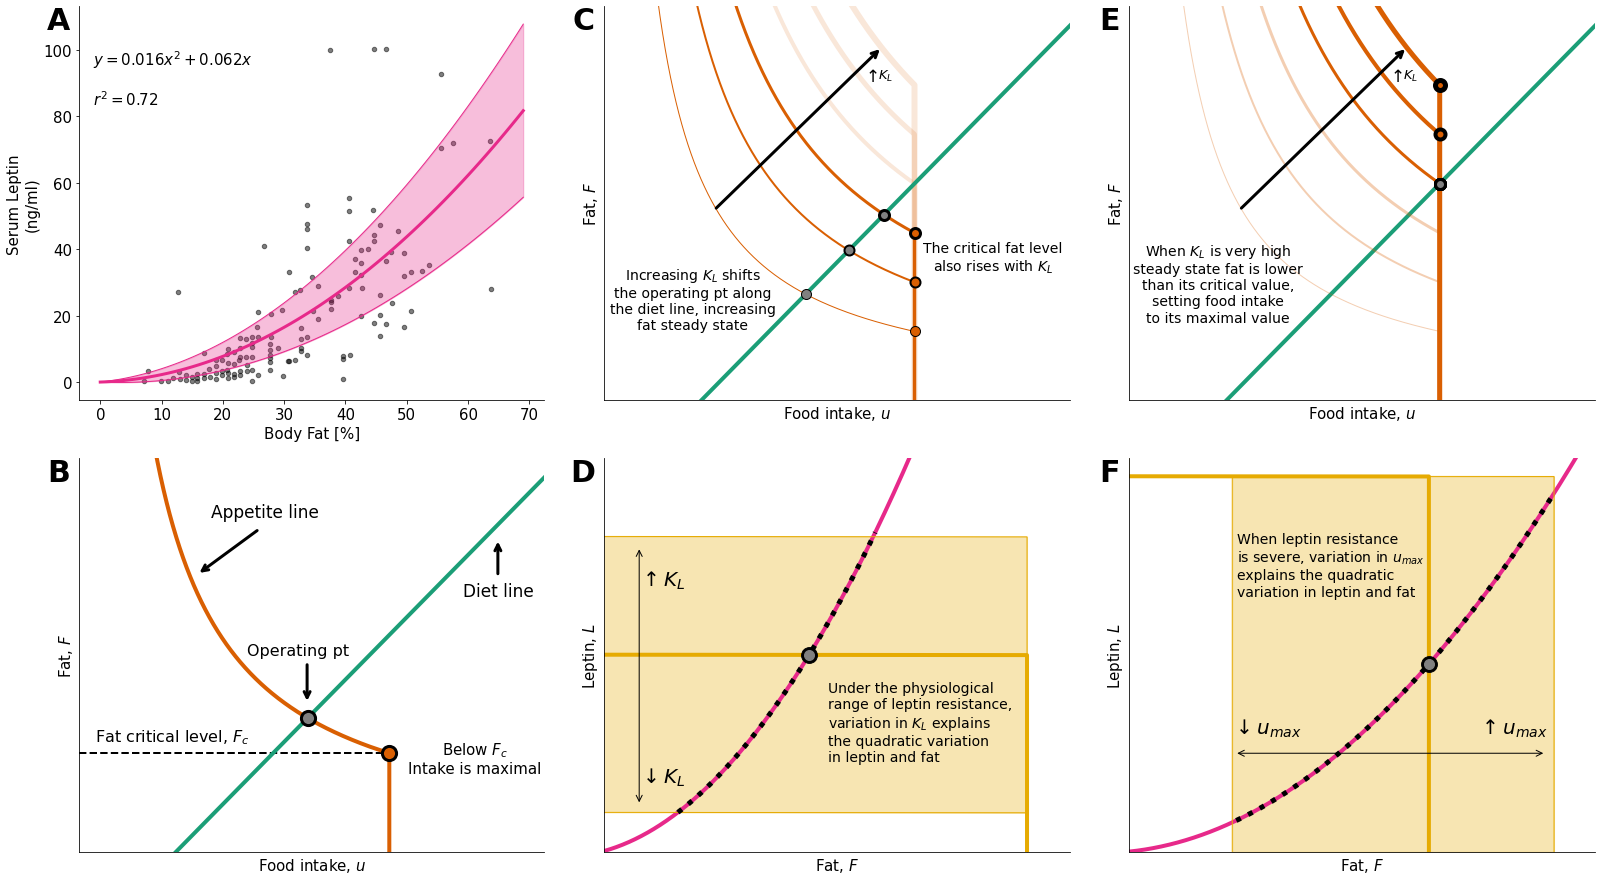

In [14]:
dF     = af*u   - bf*F - be
dL     = al*F*u - bl*L
K_L    = ks/(1+(L/kl)**n)
inv_Ku = solve(K_L - u,L)[0]
Lqst   = solve(dL,L)[0]
Lst    = Lqst.subs(u,solve(dF,u)[0])
subs   = {af:1/25,bf:1/25,al:1,bl:1,be:0.1/25,kl:0.5,ks:1}

app_ninf          = (bl*kl/(al*u))
Fc                = float(app_ninf.subs(u,ks).subs(subs))
fat_line          = solve(dF.subs(u,K_L),F)[0]
lep_line          = solve(dL.subs(u,solve(dF,u)[0]),F)[0]

k_crit            = solve(Eq(solve(dF,F)[0].subs(u,ks),app_ninf.subs(u,ks)),kl)[0]
k_crit_numeric    = k_crit.subs(subs)

diet_line_exp     = solve(dF,u)[0]
appetite_line_exp = solve(app_ninf - F,u)[0]
fstst_exp         = solve(Eq(diet_line_exp,appetite_line_exp),F)[0]
ustst_exp         = diet_line_exp.subs(F,fstst_exp).simplify()

def get_fat_null_ninf(subs):
    Fc = float((af*ks/bf - be/bf).subs(subs))
    KL = subs[kl]
    
    def fat_null_ninf(L):
        if isinstance(L, int):
            if L<KL:
                return Fc
            else:
                return 0
        else:
            fres = []
            for l in L:
                if l<KL:
                    fres.append(Fc)
                else:
                    fres.append(0)
            return np.array(fres)  
    return fat_null_ninf


'''
Figure 5 - L-F relation
'''

plt.figure(figsize=(22.5,12.5)) 
###################
ax = plt.subplot(231)
cn           = ['Body Fat [%]','Serum Leptin\n(ng/ml)']
lep_fat      = loadmat('./graphs from papers/leptin fat variation/considine_leptin_fat_variation.mat')['considine_leptin_fat_variation']
df1          = pd.DataFrame(lep_fat,columns=cn)
data         = pd.DataFrame([df1['Body Fat [%]'].values,df1['Body Fat [%]'].values**2,df1['Serum Leptin\n(ng/ml)'].values],index=['x','x2','y']).T
markers1     = ax.scatter(df1[cn[0]],df1[cn[1]],c='k',s=20,alpha=0.5)

y = data['y']
x = data[['x']]
model = sm.OLS(y, x).fit()
print('Linear model AIC', model.aic)
print('Linear model r**2', model.rsquared_adj)

y = data['y']
x = data[['x', 'x2']]
model = sm.OLS(y, x).fit()
print('Quadratic model AIC', model.aic)
print('Quadratic model r**2', model.rsquared_adj)

def func(x,a,b):
    return a*x**2 + b*x

popt,pcov = curve_fit(func,df1[cn[0]],df1[cn[1]]); perr = np.sqrt(np.diag(pcov))

r      = np.corrcoef(func(df1[cn[0]], *popt),df1[cn[1]])[0,1]
x      = np.arange(0,70)
y      = func(x, *popt)
y_plus = func(x, *(popt + perr))
y_minus= func(x, *(popt - perr))

ax.plot(x,y      ,c=def_color[4],lw=3)
ax.plot(x,y_plus ,c=def_color[4],lw=1)
ax.plot(x,y_minus,c=def_color[4],lw=1)

ax.fill_between(x, y_minus, y_plus,color=def_color[4],alpha=0.3)
ax.set_xlabel(cn[0]);ax.set_ylabel(cn[1])

exstr = '$y='+str(np.round(model.params['x2'],decimals=3))+'x^2 + ' +str(np.round(model.params['x'],decimals=3))+'x$'
ax.annotate('$r^2='+str(np.round(model.rsquared_adj,decimals=2))+'$',xy=[0.03,0.75],xycoords = 'axes fraction')
ax.annotate(exstr,xy=[0.03,0.85],xycoords = 'axes fraction')
##########
ax2 =  plt.subplot(232)
f_range          = np.linspace(0,2*float(solve(dF,F)[0].subs(subs).subs(u,subs[ks])),num=1000)
null1,null2,stst = get_numeric_nullclines_func({af:0.01,bf:0.025,al:1,bl:1,be:0.00625,kl:k_crit_numeric,ks:2})

ax2.plot(null1(f_range),f_range,c=def_color[0],lw=4)
for i,KL_ in enumerate(np.arange(0.35,1.65,0.25)):
    subs = {af:0.01,bf:0.025,al:1,bl:1,be:0.00625,kl:KL_,ks:2}
    null1,null2,stst = get_numeric_nullclines_func(subs)
    if KL_ < 1.1:
        ax2.plot(null2(f_range),f_range,c=def_color[1],lw=i+1)
        fc = ((KL_*bl)/(al*ks)).subs(subs)
        ax2.scatter(subs[ks],fc,c=def_color[1],zorder=5,s=100,edgecolor='k',lw=1+i)
        
        if KL_ > k_crit.subs(subs):
            ax2.scatter(subs[ks],solve(dF,F)[0].subs(u,ks).subs(subs),s=100,c='gray',zorder=4,edgecolor='k',lw=3)
        else:
            ax2.scatter(stst[0],stst[1],s=100,c='gray',zorder=4,edgecolor='k',lw=i+1)
        
    else:
         ax2.plot(null2(f_range),f_range,c=def_color[1],lw=i+1,alpha=0.15,zorder=-3)
               

fmt_ax(ax2,subs); ax2.set_ylim([0,1]);ax2.set_xlim([0,3])
ax2.annotate(xy = [0.19,0.18],xycoords='axes fraction',text='Increasing $K_L$ shifts\nthe operating pt along\nthe diet line, increasing\nfat steady state',fontsize=14,ha='center')
ax2.annotate(xy = [0.225,0.47],xytext=[0.6,0.9],xycoords='axes fraction',text='',arrowprops=aps_k,zorder=4)
ax2.annotate(xy = [0.57,0.81],xycoords='axes fraction',text=r'$\uparrow$',fontsize=17,ha='center')
ax2.annotate(xy = [0.605,0.815],xycoords='axes fraction',text='$K_L$',fontsize=13,ha='center')
ax2.annotate(xy = [0.835,0.33],xycoords='axes fraction',text='The critical fat level\nalso rises with $K_L$',fontsize=14,ha='center')


##########
ax3 =  plt.subplot(233)
f_range = np.linspace(0,2*float(solve(dF,F)[0].subs(subs).subs(u,subs[ks])),num=1000)

ax3.plot(null1(f_range),f_range,c=def_color[0],lw=4)
for i,KL_ in enumerate(np.arange(0.35,1.65,0.25)):
    subs   = {af:0.01,bf:0.025,al:1,bl:1,be:0.00625,kl:KL_,ks:2}
    null1,null2,stst = get_numeric_nullclines_func(subs)
    if KL_ > 1:
        ax3.plot(null2(f_range),f_range,c=def_color[1],lw=i)
        fc = ((KL_*bl)/(al*ks)).subs(subs)
        ax3.scatter(subs[ks],fc,c=def_color[1],zorder=5,s=100,edgecolor='k',lw=i)
    else:
         ax3.plot(null2(f_range),f_range,c=def_color[1],lw=i+1,alpha=0.3)
            
    ax3.scatter(subs[ks],solve(dF,F)[0].subs(u,ks).subs(subs),s=100,c='gray',zorder=10,edgecolor='k',lw=3)


fmt_ax(ax3,subs); ax3.set_ylim([0,1]);ax3.set_xlim([0,3])
ax3.annotate(xy = [0.225,0.47],xytext=[0.6,0.9],xycoords='axes fraction',text='',arrowprops=aps_k,zorder=4)
ax3.annotate(xy = [0.57,0.81],xycoords='axes fraction',text=r'$\uparrow$',fontsize=17,ha='center')
ax3.annotate(xy = [0.605,0.815],xycoords='axes fraction',text='$K_L$',fontsize=13,ha='center')
ax3.annotate(xy = [0.19,0.2],xycoords='axes fraction',text='When $K_L$ is very high\nsteady state fat is lower\nthan its critical value,\nsetting food intake\nto its maximal value',fontsize=14,ha='center')

###################
ax4 = plt.subplot(234)
subs   = {af:0.01,bf:0.025,al:1,bl:1,be:0.00625,kl:0.5,ks:2}

null1,null2,stst = get_numeric_nullclines_func(subs)
fc = ((kl*bl)/(al*ks)).subs(subs)

ax4.plot(null1(f_range),f_range,color=def_color[0],lw=4)
ax4.plot(null2(f_range),f_range,color=def_color[1],lw=4)
ax4.scatter(stst[0],stst[1],s=200,color='gray',zorder=4,edgecolor='k',lw=3)
ax4.scatter(subs[ks],fc,color=def_color[1],zorder=5,s=200,edgecolor='k',lw=3)
ax4.plot([0,subs[ks]],[fc,fc],lw=2,ls='--',color='k',zorder=-5)
fmt_ax(ax4,subs); ax4.set_ylim([0,1]);ax4.set_xlim([0,3])

ax4.annotate(xy = [0.47,0.5],xycoords='axes fraction',text='Operating pt',fontsize=16,ha='center')
ax4.annotate(xy = [0.49,0.5],xytext=[0.49,0.37],xycoords='axes fraction',text='',arrowprops=aps_k,zorder=4)

ax4.annotate(xy = [0.2,0.28],xycoords='axes fraction',text='Fat critical level, $F_c$',fontsize=16,ha='center')
ax4.annotate(xy = [0.85,0.2],xycoords='axes fraction',text='Below $F_c$\nIntake is maximal',fontsize=15,ha='center')
ax4.annotate(xy = [0.9,0.65],xycoords='axes fraction',text='Diet line'    ,fontsize=17,ha='center')
ax4.annotate(xy = [0.4,0.85],xycoords='axes fraction',text='Appetite line',fontsize=17,ha='center')
ax4.annotate(xy = [0.4,0.83],xytext=[0.25,0.7],xycoords='axes fraction',text='',arrowprops=aps_k,zorder=4)
ax4.annotate(xy = [0.9,0.68],xytext=[0.9,0.8],xycoords='axes fraction',text='',arrowprops=aps_k,zorder=4)

###################
ax5 = plt.subplot(235)
subs    = {af:0.02,bf:0.025,al:1,bl:1.5,be:0.00625,kl:0.5,ks:2}

lep_null = lambdify(L,lep_line.subs(subs))
l_range  = np.arange(0,2,0.001)
ax5.plot(lep_null(l_range),l_range,c=def_color[4],lw=4)
x0,x1,x2 = [get_fat_null_ninf({af:0.02,bf:0.025,al:1,bl:1.5,be:0.00625,kl:kl_,ks:2})(l_range) for kl_ in [0.5,0.1,0.8]]
ax5.plot(x0,l_range,color=def_color[2],lw=4)
ax5.plot(x1,l_range,color=def_color[2],lw=1)
ax5.plot(x2,l_range,color=def_color[2],lw=1)
ax5.fill_betweenx(l_range, x1, x2,color=def_color[2],alpha=0.3)

eq       = Eq(lep_line,fat_line).subs(subs)
lst      = subs[kl]# nsolve(eq,1)
fst      = lep_line.subs(subs).subs(L,lst)
stst     = np.array([fst,lst]).astype(float)
ax5.scatter(stst[0],stst[1],color='gray',s=100,zorder=4); ax5.scatter(stst[0],stst[1],color='k',s=250,zorder=3)
ax5.plot(lep_null(np.arange(0.1,0.82,0.01)),np.arange(0.1,0.82,0.01),color='k',lw=5,ls='dotted')
fat_null = get_fat_null_ninf(subs)# lambdify(L,fat_line.subs(subs))
ax5.set_xlim([0.01,fat_null(0)*1.1])
ax5.set_ylim([0,subs[kl]*2])
ax5.set_xticks([]); ax5.set_ylabel('Leptin, $L$')
ax5.set_yticks([]); ax5.set_xlabel('Fat, $F$')
ax5.annotate(xy = [0.48,0.23],xycoords = 'axes fraction',text='Under the physiological\nrange of leptin resistance,\nvariation in $K_L$ explains\nthe quadratic variation\nin leptin and fat',fontsize=14)
ax5.annotate(xy = [0.075,0.1],xytext=[0.075,0.78],xycoords='axes fraction',text='',zorder=4,arrowprops=aps_flowd)
ax5.annotate(xy = [0.075,0.675],xycoords = 'axes fraction', text=r'$\uparrow$$K_L$',fontsize=20)
ax5.annotate(xy = [0.075,0.175]  ,xycoords = 'axes fraction', text=r'$\downarrow$$K_L$',fontsize=20)

###################################
ax6 = plt.subplot(236)

lep_null = lambdify(L,lep_line.subs(subs))
l_range  = np.arange(0,4,0.001)
ax6.plot(lep_null(l_range),l_range,color=def_color[4],lw=4)

k_c     = solve(Eq(solve(dF,F)[0].subs(u,ks),app_ninf.subs(u,ks)),kl)[0]
k_c_num = k_c.subs(subs)
x0,x1,x2 = [get_fat_null_ninf({af:0.02,bf:0.025,al:1,bl:1.5,be:0.00625,kl:k_c_num*2,ks:ks_})(l_range) for ks_ in [2,0.9,2.7]]
ax6.plot(x0,l_range,color=def_color[2],lw=4)
ax6.plot(x1,l_range,color=def_color[2],lw=1)
ax6.plot(x2,l_range,color=def_color[2],lw=1)
ax6.fill_betweenx(l_range, x1, x2,color=def_color[2],alpha=0.3)

lst     = k_c_num
fst     = solve(dF,F)[0].subs(u,ks).subs(subs)
stst    = np.array([fst,lst]).astype(float)
ax6.scatter(stst[0],stst[1],color='gray',s=100,zorder=4); ax6.scatter(stst[0],stst[1],color='k',s=250,zorder=3)
ax6.plot(lep_null(np.arange(0.3,3.4,0.01)),np.arange(0.3,3.4,0.01),color='k',lw=5,ls='dotted')
ax6.set_xlim([0.01,stst[0]*1.55])
ax6.set_ylim([0,stst[1]*2.1])
ax6.set_xticks([]); ax6.set_ylabel('Leptin, $L$')
ax6.set_yticks([]); ax6.set_xlabel('Fat, $F$')
ax6.annotate(xy = [0.23,0.65],xycoords = 'axes fraction',text='When leptin resistance\nis severe, variation in $u_{max}$\nexplains the quadratic\nvariation in leptin and fat',fontsize=14)
ax6.annotate(xy = [0.21,0.25],xytext=[0.9,0.25],xycoords='axes fraction',text='',zorder=4,arrowprops=aps_flowd)
ax6.annotate(xy = [0.22,0.3],xycoords = 'axes fraction', text=r'$\downarrow$$u_{max}$',fontsize=20)
ax6.annotate(xy = [0.75,0.3]  ,xycoords = 'axes fraction', text=r'$\uparrow$$u_{max}$',fontsize=20)

remove_top_right_frame([ax,ax2,ax3,ax4,ax5,ax6]); 
[ax.text(-0.02,1,abc[i],transform=ax.transAxes,fontsize = 30,fontweight='bold',va='top',ha='right') for i,ax in enumerate([ax,ax4,ax2,ax5,ax3,ax6])]
plt.tight_layout(); plt.show()

# Fig 6 - model comparison

<string>:2: RuntimeWarning: invalid value encountered in power


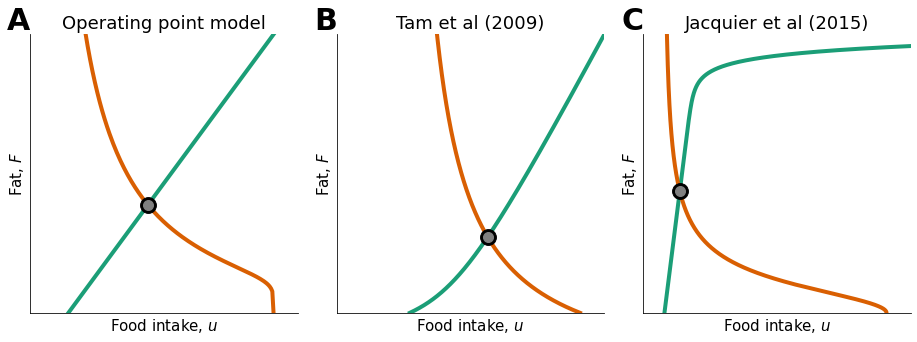

In [9]:
def plot_models_nullclines(diet,app,subs,ax = [],ylm=[],xlm = [],plot_rect = False, rectx= 0.5,recty=0.5):
    if not ax:
        ax = plt.subplot(111)
    
    #numerically solve stst
    eq    = Eq(app,diet).subs(subs)
    fst   = nsolve(eq,1)
    ust   = diet.subs(subs).subs(F,fst)
    stst  = np.array([ust,fst]).astype(float)

    f_diet= lambdify(F,diet.subs(subs))
    f_app = lambdify(F,app.subs(subs))
    if not xlm:
        xlm     = f_app(0)*1.1
    
    if not ylm:
        ylm     = float(nsolve(diet.subs(subs).simplify()-xlm,fst))      
    f_range = np.arange(0,ylm,0.01)
      
    # plot
    ax.plot(f_diet(f_range),f_range,c=def_color[0],lw=4)
    ax.plot(f_app(f_range) ,f_range,c=def_color[1],lw=4)
    ax.scatter(ust,fst,c='gray',s=100,zorder=4)
    ax.scatter(ust,fst,c='k',s=250,zorder=3)

    ax.set_xlim([0,xlm]); ax.set_xticks([]); ax.set_xlabel('Food intake, ${u}$')
    ax.set_ylim([0,ylm]); ax.set_yticks([]); ax.set_ylabel('Fat, $F$')  
    
    if plot_rect:
        rect = mpatches.Rectangle((stst[0]*(1-rectx),stst[1]*(1-recty)),
                                  stst[0]*(2*rectx) ,stst[1]*(2*recty),
                                  linewidth=1, edgecolor='k', facecolor='none')
        ax.add_patch(rect)
    

def plot_models_nullclines_by_u(diet,app,subs,ax = [],ylm=[],xlm = [],plot_rect = False, rectx= 0.5,recty=0.5):
    if not ax:
        ax = plt.subplot(111)
    
    #numerically solve stst
    eq    = Eq(app,diet).subs(subs)
    ust   = nsolve(eq,1)
    fst   = diet.subs(subs).subs(u,ust)
    stst  = np.array([ust,fst]).astype(float)

    u_diet= lambdify(u,diet.subs(subs))
    u_app = lambdify(u,app.subs(subs))
    if not xlm:
        xlm     = subs[ks] +0.01
    
    if not ylm:
        ylm     = float(op_diet.subs(op_subs).subs(u,op_subs[ks]))      
    u_range = np.arange(0.01,xlm,0.01)
      
    # plot
    ax.plot(u_range,u_diet(u_range),c=def_color[0],lw=4)
    ax.plot(u_range ,u_app(u_range),c=def_color[1],lw=4)
    ax.scatter(ust,fst,c='gray',s=100,zorder=4)
    ax.scatter(ust,fst,c='k',s=250,zorder=3)
    ax.set_xlim([0,xlm]); ax.set_xticks([]); ax.set_xlabel('Food intake, ${u}$')
    ax.set_ylim([0,ylm]); ax.set_yticks([]); ax.set_ylabel('Fat, $F$')  
    
    if plot_rect:
        rect = mpatches.Rectangle((stst[0]*(1-rectx),stst[1]*(1-recty)),
                                  stst[0]*(2*rectx) ,stst[1]*(2*recty),
                                  linewidth=1, edgecolor='k', facecolor='none')
        ax.add_patch(rect)

'''
Figure 6 - model comparison
'''

### operating point model with n=6
# model equations
F,u,L,af,bf,be,al,bl,ks,kl = symbols('F,u,L,a_F,\gamma_F,\gamma_\epsilon,a_L,\gamma_L,u_{max},K_L',positive=True)
dF      = af*u - bf*F - be
dL      = al*F*u - bl*L
K_L     = ks/(1+(L/kl)**6)
inv_Ku  = solve(K_L - u,L)[1]
Lqst    = solve(dL,L)[0]
Lst     = Lqst.subs(u,solve(dF,u)[0]) 
op_app  = solve(dL.subs(L,inv_Ku),F)[0].simplify()
op_diet = solve(dF,F)[0]
op_subs = {af:0.8*0.025 ,bf:1*0.025,al:1,bl:1,be:0.25*0.025,kl:0.5,ks:2}

### Tam et al (2009)
# model equations
k1,k2,k3,k4,k5,k6,k7,k8 = symbols('K_1,K_2,K_3,K_4,K_5,K_6,K_7,K_8'      ,positive=True)
L_p,L_b,p_food,FFM      = symbols('L_{plasma},L_{brain},\\rho_{food},FFM',positive=True)
BM       = F+FFM
dL_p_dt  = F*al - L_p*bl                 
L_b_     = k1*L_p/(k2 + L_p) + k3*L_p
Food_in_ = k4*(1-L_b/(k5 + L_b))      
E_in_    = p_food*u                   
E_out_   = k6*BM*(1+k7*L_b/(k8+L_b)); 
dE       = E_in_-E_out_
Lp_qst   = solve(dL_p_dt,L_p)[0]
Lb_qst   = L_b_.subs(L_p,Lp_qst).simplify()
tam_diet = solve(dE,u)[0].subs(L_b,Lb_qst).simplify()
tam_app  = Food_in_.subs(L_b,Lb_qst).simplify()
tam_subs = {k1:1.42,k2:15.6,k3:0.0027,k4:5.6,k5:0.55,k6:244.32,k7:1,k8:0.22,bl:284.4/4, al:51.84,p_food:3200,FFM:22}

### Jacquier et al (2015) with n=2
bE,bo,pffm,pf     = symbols('\\gamma_E,\\gamma_{\\Omega},\\rho_{FFM},\\rho_{F}',positive=True)
a,k,e,C,eta,xi    = symbols('\\alpha,\\kappa,e,C,\\eta,\\xi'                   ,positive=True)
bu,lu,theta,phi_R = symbols('\\gamma_u,\\delta_u,\\theta,\\phi_R'              ,positive=True)
bl,ll             = symbols('\\gamma_L,\\delta_L'                              ,positive=True)
dF       = (bE*u - eta*((pf+pffm*bo)*F+(pffm*a*e**(k*F))/k + pffm*C+xi))/(pffm*bo*(1+a*e**(k*F)) +pf)
du       = bu*(L**2+theta**2)/((1+phi_R)*L**2+theta**2) - lu*u
dL       = F*bl - ll*L
Lqst     = solve(dL,L)[0]
jac_diet = solve(dF,u)[0]
jac_app  = solve(du.subs(L,Lqst).simplify(),u)[0]
jac_subs = {e:np.e,bE:1,bo:2.2,pffm:9.4,pf:1.8,a:7.27e-10,k:0.269,C:1,eta:1.77e-5,xi:1413.6,bu:3.46e-4,lu:1.19e-3,theta:57.22,bl:0.0954,ll:0.074,phi_R:11}


plt.figure(figsize=(13,5))
ax1,ax2,ax3 = plt.subplot(131),plt.subplot(132),plt.subplot(133)

plot_models_nullclines_by_u(op_diet ,op_app ,op_subs ,ax=ax1,xlm=op_subs[ks]*1.1)
plot_models_nullclines(tam_diet,tam_app,tam_subs,ax=ax2)
plot_models_nullclines(jac_diet,jac_app,jac_subs,ax=ax3,ylm=105)

ax1.set_title('Operating point model')
ax2.set_title('Tam et al (2009)')
ax3.set_title('Jacquier et al (2015)')

remove_top_right_frame([ax1,ax2,ax3])
[ax.text(0,1.1,abc[i],transform=ax.transAxes,fontsize = 30,fontweight='bold',va='top',ha='right') for i,ax in enumerate([ax1,ax2,ax3])]
plt.tight_layout(); plt.show()

# FIG S1

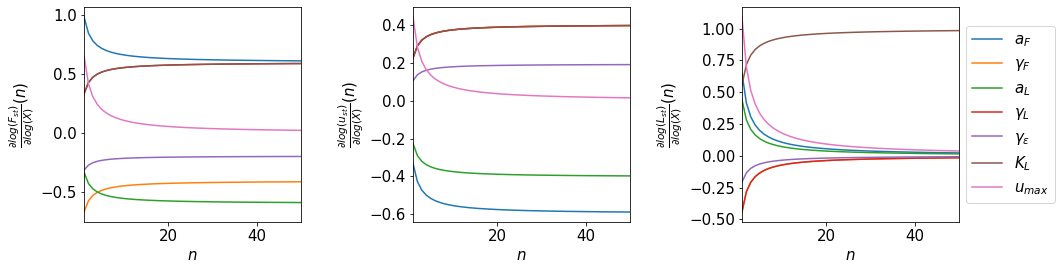

In [10]:
'''
Figure S1 - sensitivity analysis
'''
f_of,u_of,l_of,X = Function('F'),Function('u'),Function('L'),symbols('X')

dF     = af*u   - bf*F - be
dL     = al*F*u - bl*L
K_L    = ks/(1+(L/kl)**n)
inv_Ku = solve(K_L - u,L)[0]
Lqst   = solve(dL,L)[0]
diet_  = solve(dF,F)[0]
app_   = solve(dL.subs(L,inv_Ku),F)[0].simplify().subs(kl**n,1).subs(bl,bl*kl)

n_,d_  = fraction(cancel(solve(dF,F)[0].subs(u,K_L.subs(L,Lst))))  ; eqF = F*d_ - n_  
n_,d_  = fraction(cancel(K_L.subs(L,Lst.subs(F,solve(dF,F)[0]))))  ; equ = u*d_ - n_  
n_,d_  = fraction(cancel(Lqst.subs(F,solve(dF,F)[0]).subs(u,K_L))) ; eqL = L*d_ - n_  
subs                   = {af:0.02,bf:0.025,al:1,bl:1,be:0.00625,kl:0.5,ks:2}
pars                   = list(subs.keys())
partial_derivaitives   = pd.DataFrame(index=pars,columns = ['F','u','L'])
partial_derivaitives.F = [solve(eqF.subs(F,f_of(par)).diff(par),f_of(par).diff(par))[0].simplify() for par in pars]
partial_derivaitives.u = [solve(equ.subs(u,u_of(par)).diff(par),u_of(par).diff(par))[0].simplify() for par in pars]
partial_derivaitives.L = [solve(eqL.subs(L,l_of(par)).diff(par),l_of(par).diff(par))[0].simplify() for par in pars]

# Given aconstant set of parameters, we numerically solve the steady state for different values of n
usts,fsts,lsts = [],[],[]
n_range = np.arange(1,51,1).astype(float)
for n_ in n_range:
    ust  = nsolve(Eq(app_,diet_).subs(subs).subs(n,n_),u,1)  ; usts.append(ust)
    fst  = diet_.subs(subs).subs(u,ust)                      ; fsts.append(fst)
    lst  = Lst.subs(subs).subs(F,fst)                        ; lsts.append(lst)

# Given aconstant set of parameters, we regard the analytical expressions for the parital derivatives as functions of n
# Then we numerically calculate the log-partial derivative for every value of n, using the precalculated numerical values of the steady states
plt.figure(figsize=(15,4)); ax1,ax2,ax3 = plt.subplot(131),plt.subplot(132),plt.subplot(133)
for p in range(len(pars)):
    f_p_change = lambdify((n,F),partial_derivaitives.F.iloc[p].subs(f_of(pars[p]),F).subs(subs))    
    u_p_change = lambdify((n,u),partial_derivaitives.u.iloc[p].subs(u_of(pars[p]),u).subs(subs))    
    l_p_change = lambdify((n,L),partial_derivaitives.L.iloc[p].subs(l_of(pars[p]),L).subs(subs))    

    ax1.plot(n_range,f_p_change(n_range,np.array(fsts))*(subs[pars[p]]/np.array(fsts))); 
    ax2.plot(n_range,u_p_change(n_range,np.array(usts))*(subs[pars[p]]/np.array(usts))); 
    ax3.plot(n_range,l_p_change(n_range,np.array(lsts))*(subs[pars[p]]/np.array(lsts))); 

[ax.set_xlabel('$n$') for ax in [ax1,ax2,ax3]]
[ax.set_xlim([1,50]) for ax in [ax1,ax2,ax3]]
ax1.set_ylabel(r"$\frac{\partial log(F_{st})}{\partial log(X)}(n)$")
ax2.set_ylabel(r"$\frac{\partial log(u_{st})}{\partial log(X)}(n)$")
ax3.set_ylabel(r"$\frac{\partial log(L_{st})}{\partial log(X)}(n)$")
ax3.legend(['$'+str(par)+'$' for par in pars] ,loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(); plt.show()

<IPython.core.display.Latex object>

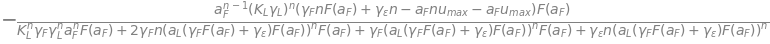

<IPython.core.display.Latex object>

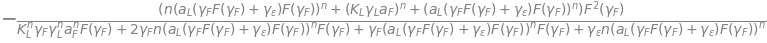

<IPython.core.display.Latex object>

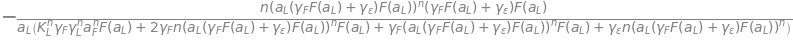

<IPython.core.display.Latex object>

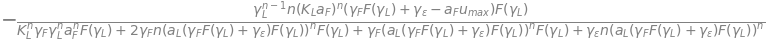

<IPython.core.display.Latex object>

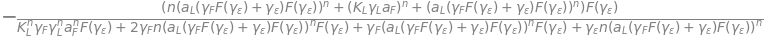

<IPython.core.display.Latex object>

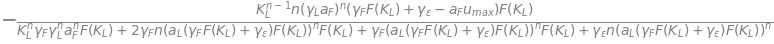

<IPython.core.display.Latex object>

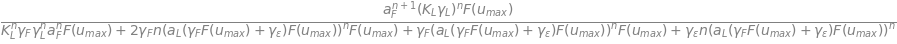

<IPython.core.display.Latex object>

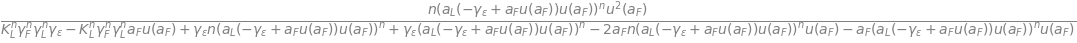

<IPython.core.display.Latex object>

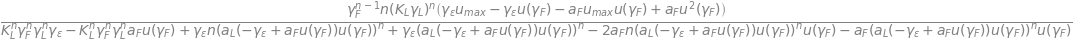

<IPython.core.display.Latex object>

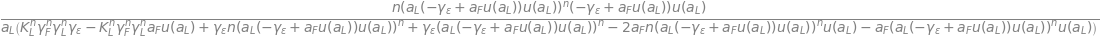

<IPython.core.display.Latex object>

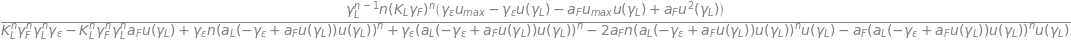

<IPython.core.display.Latex object>

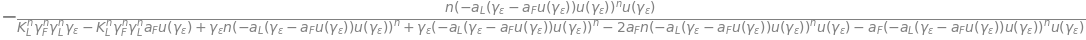

<IPython.core.display.Latex object>

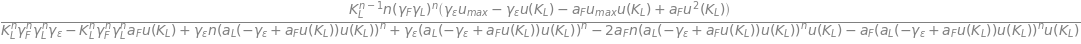

<IPython.core.display.Latex object>

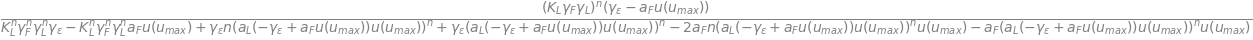

<IPython.core.display.Latex object>

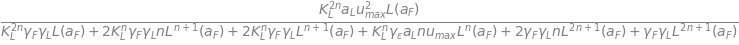

<IPython.core.display.Latex object>

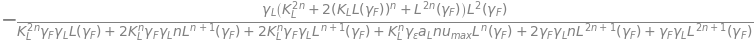

<IPython.core.display.Latex object>

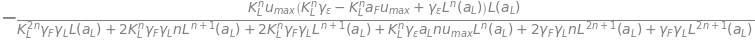

<IPython.core.display.Latex object>

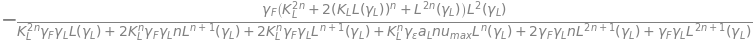

<IPython.core.display.Latex object>

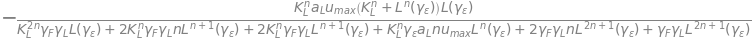

<IPython.core.display.Latex object>

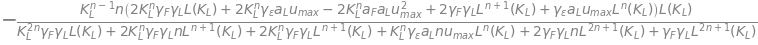

<IPython.core.display.Latex object>

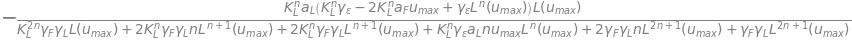

[None, None, None, None, None, None, None]

In [11]:
display(Eq(0,eqF))
display(Eq(0,equ))
display(Eq(0,eqL))

from IPython.display import display, Latex
[display(Latex('$\\frac{\\partial F_{st}}{\\partial '+str(par)+'}$ = '),partial_derivaitives['F'][par]) for par in pars]
[display(Latex('$\\frac{\\partial u_{st}}{\\partial '+str(par)+'}$ = '),partial_derivaitives['u'][par]) for par in pars]
[display(Latex('$\\frac{\\partial L_{st}}{\\partial '+str(par)+'}$ = '),partial_derivaitives['L'][par]) for par in pars]